In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime


# ml
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import pandas as pd

In [20]:
print(tf.__version__)

2.2.0


In [77]:
class StockPredictor():
    
    hist_start   = '2010-01-01'
    sequence_len = 60
    epoch        = 10
    batch_size   = 30
    
    def __init__(self, ticker_sym):
        self.ticker = yf.Ticker(ticker_sym)
        self.ticker_df, self.train_data, self.test_data = self.fetch_ticker_data()
        self.model = Sequential()
        
    def fetch_ticker_data(self):
        
        # step 1 - fetch data
        hist_end = datetime.datetime.today().strftime('%Y-%m-%d')
        ticker_df = self.ticker.history(interval='1d', start=self.hist_start, end=end)
        
        # step 2 - clean data
        ticker_df = ticker_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1)
        ticker_df.dropna()
    
        # step 3 - scale
        scaler = MinMaxScaler()
        ticker_df = scaler.fit_transform(ticker_df)
        
        # step 4 - split data
        train_data, test_data = train_test_split(ticker_df, shuffle=False)
                
        return ticker_df, train_data, test_data
    
    @staticmethod
    def sequence_data(series_data, sequence_len):
        X = []
        y = []
        
        for i in range(sequence_len, series_data.shape[0]):
            X.append(series_data[i-sequence_len:i])
            y.append(series_data[i, 0])

        return np.array(X), np.array(y)
        
    def train(self):

        # step 1 - sequence data
        X_train, y_train = StockPredictor.sequence_data(self.train_data, self.sequence_len)
        
        # step 2 - build model
        self.build_model( (X_train.shape[1],X_train.shape[2]) )

        # step 3 - fit
        self.model.fit(X_train, y_train, epochs=10, batch_size=30)
        
    def test(self):
        
        # step 1 - sequence data
        X_test, y_test = StockPredictor.sequence_data(self.test_data, self.sequence_len)
        
        # step 2 - predict
        pred = self.model.predict(X_test)
        
        # step 3 - evaluate
        snrdB = 10*np.log10(np.sum(np.square( pred[:,59] - y_test ))/np.sum(np.square(y_test)))
 
        return snrdB
    
    def build_model(self, input_shape):

        self.model.add(LSTM(units=60, activation='relu', return_sequences=True, input_shape = input_shape))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units=120, activation='relu', return_sequences=True))
        self.model.add(Dropout(0.6))

        self.model.add(LSTM(units=80, activation='relu', return_sequences=True))
        self.model.add(Dropout(0.2))
        
        self.model.add(Dense(1))
        self.model.build()
        
        self.model.summary()
        
        self.model.compile(optimizer='adam', loss='mean_squared_error')
    
    def predict(self, date):
        pass

In [78]:
s = StockPredictor('aapl')

In [79]:
s.train()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 60)            15600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 120)           86880     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            64320     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 1)           

In [80]:
s.test()

19.444270039196127

# 1. data

In [6]:
# get stock data for ticker
ticker = yf.Ticker('aapl')

start ='2010-01-01'
end   = datetime.datetime.today().strftime('%Y-%m-%d')

ticker_df = ticker.history(interval='1d', start=start, end=end)

In [8]:
ticker_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,26.36,26.39,26.04,26.06,88102700,0.0,0.0
2010-01-04,26.40,26.53,26.27,26.47,123432400,0.0,0.0
2010-01-05,26.54,26.66,26.37,26.51,150476200,0.0,0.0
2010-01-06,26.51,26.62,26.06,26.09,138040000,0.0,0.0
2010-01-07,26.19,26.22,25.85,26.04,119282800,0.0,0.0


In [9]:
ticker_df = ticker_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1)

In [10]:
# check for nulls
ticker_df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [11]:
ticker_df.dropna()

,Open,High,Low,Close
Date,,,,
2009-12-31,26.36,26.39,26.04,26.06
2010-01-04,26.40,26.53,26.27,26.47
2010-01-05,26.54,26.66,26.37,26.51
2010-01-06,26.51,26.62,26.06,26.09
2010-01-07,26.19,26.22,25.85,26.04
...,...,...,...,...
2020-07-06,370.00,375.78,369.87,373.85
2020-07-07,375.41,378.62,372.23,372.69
2020-07-08,376.72,381.50,376.36,381.37


Text(0.5, 1.0, 'Apple stock history')

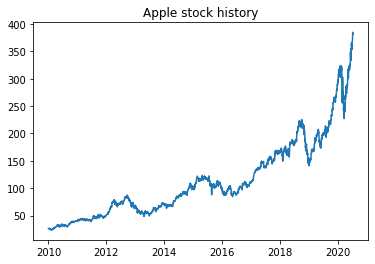

In [12]:
plt.plot(ticker_df['Open'])
plt.title('Apple stock history')

In [18]:
# train/test split
train_data, test_data = train_test_split(ticker_df, shuffle=False)

In [152]:
scaler = MinMaxScaler()

training_data = scaler.fit_transform(ticker_df[:'2019-01-01'])
training_data.shape

(2265, 4)

In [102]:
# train and test data

X_train = []
y_train = []

for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    y_train.append(training_data[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [103]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')

X_train.shape = (2584, 60, 4)
y_train.shape = (2584,)


# 2. Model

In [104]:
regressor = Sequential()

regressor.add(LSTM(units=60, activation='relu', return_sequences=True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=80, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(Dense(1))
regressor.build()

In [105]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 60)            15600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 1)             81        
Total params: 60,801
Trainable params: 60,801
Non-trainable params: 0
_________________________________________________________________


In [106]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

# 3. train

In [107]:
regressor.fit(X_train, y_train, epochs=10, batch_size=30)

Epoch 1/10
87/87 [==============================] - 7s 85ms/step - loss: 0.0122
Epoch 2/10
87/87 [==============================] - 7s 75ms/step - loss: 0.0055
Epoch 3/10
87/87 [==============================] - 5s 63ms/step - loss: 0.0044
Epoch 4/10
87/87 [==============================] - 5s 60ms/step - loss: 0.0038
Epoch 5/10
87/87 [==============================] - 6s 64ms/step - loss: 0.0035
Epoch 6/10
87/87 [==============================] - 6s 64ms/step - loss: 0.0032
Epoch 7/10
87/87 [==============================] - 5s 60ms/step - loss: 0.0031
Epoch 8/10
87/87 [==============================] - 6s 65ms/step - loss: 0.0028
Epoch 9/10
87/87 [==============================] - 6s 64ms/step - loss: 0.0028
Epoch 10/10
87/87 [==============================] - 5s 63ms/step - loss: 0.0028


Text(0.5, 1.0, 'train data')

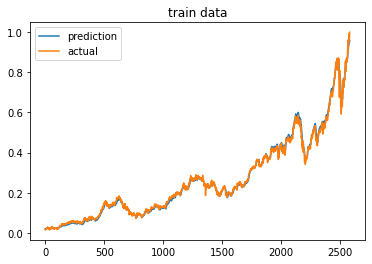

In [158]:
pred = regressor.predict(X_train)
plt.plot(pred[:,59])
plt.plot(y_train)
plt.legend(['prediction', 'actual'])
plt.title('train data')

# 4. evaluate

In [155]:
# evaluate on test data
test_data = scaler.fit_transform(ticker_df['2019-01-01':])
test_data.shape

(379, 4)

In [157]:
X_test = []
y_test = []
for i in range(60, test_data.shape[0]):
    X_test.append(test_data[i-60:i])
    y_test.append(test_data[i, 0])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

Text(0.5, 1.0, 'train data')

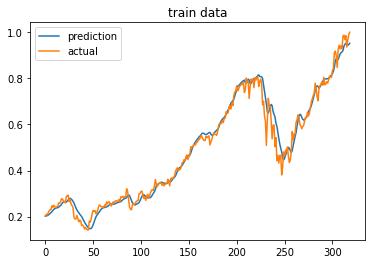

In [159]:
pred = regressor.predict(X_test)
plt.plot(pred[:,59])
plt.plot(y_test)
plt.legend(['prediction', 'actual'])
plt.title('train data')

In [166]:
# metrics
snr = 10*np.log10(np.sum(np.square( pred[:,59] - y_test ))/np.sum(np.square(y_test)))
snr

20.634985770504272